In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.backends import backend_pdf as bpdf
from community_simulator.usertools import MakeConsumerDynamics,MakeResourceDynamics,MakeMatrices,MakeInitialState
from community_simulator import Community
from community_simulator.visualization import PlotTraj, StackPlot
import pickle
import biom
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa
%matplotlib inline

In [2]:
mp = {
      'regulation':'independent',
      'supply':'external',
      'response':'type I'
     }

#Construct dynamics
def dNdt(N,R,params):
    return MakeConsumerDynamics(mp)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(mp)(N,R,params)
dynamics = [dNdt,dRdt]

In [3]:
#LOAD AND PROCESS DATA
with open('data/HMP_env_family.dat','rb') as f:
    N,R,params_1,R0,metadata = pickle.load(f)
#Append information about resource mixtures
alpha = np.linspace(0,1,int(round(len(N.T)/3)))
metadata['alpha'] = np.hstack((alpha,alpha,alpha))
#Remove failed runs
composite = N.T.join(metadata).join(R0.T)
composite = composite.dropna()
metadata = composite[['alpha','Environment']]
R0 = composite[R0.index].T
N = N.T.dropna().T
R = R.T.dropna().T
#Reconstruct community
params = [{}]*len(N.T)
for k in range(len(N.T)):
    for item in ['w','g','l','tau','c','D','m']:
        params[k][item] = params_1[item]
    params[k]['R0'] = R0.values[:,k]

params_1['w'] = np.random.lognormal(0, 1, size=R.shape[0])  
# turn the first node into a real source
params_1['w'][0] = np.ceil(params_1['w'].max())
HMP = Community([N,R],dynamics,params)
HMP.metadata=metadata

/Users/jmorton/miniconda3/envs/mcrm/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/Users/jmorton/miniconda3/envs/mcrm/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


First, let's try to build a topological network given w.  The w is directly proportional to the Gibb's free energy if the concentration is constant.  We'll make the simplifying assumption that it is constant for now so that we can construct the network of reactions.

Since a reaction is considered favorable if the $\Delta G$ is negative, we'll assign edges for only the favorable reactions.

In [4]:
from scipy.spatial.distance import pdist, squareform
import networkx as nx

G = nx.DiGraph()
L = params_1['w']
for i, x in enumerate(params_1['w']):
    for j, y in enumerate(params_1['w']):
        if x - y < 0:
            G.add_edge(i, j)
        elif y - x < 0:
            G.add_edge(j, i)
len(G.edges)            

44850

Outstanding questions

How can we streamline interactions?  Right now, we are deriving the network from the Gibb's free energy.
But this won't be able to handle intermediate reactions very well - it's not clear how to encode the pyruvate cycle for instance.

/Users/jmorton/miniconda3/envs/mcrm/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/jmorton/miniconda3/envs/mcrm/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


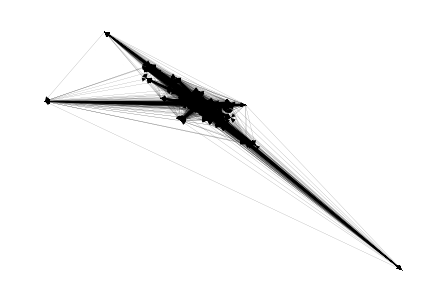

In [5]:
from networkx.drawing.nx_pydot import graphviz_layout

options = {
    'node_color': 'black',
    'node_size': 1,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
#pos = graphviz_layout(G, prog="twopi", root=0)
pos = nx.spectral_layout(G)

nx.draw(G, pos=pos, **options)

In [ ]:
out = HMP.TestWell(T = 100)